<a href="https://colab.research.google.com/github/jposyluzny/ENEL645/blob/main/Lectures/Week%204/CNN_MNISTDigits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step-by-step MNIST Digits Classification - Convolutional Neural Networks

1. Load dataset, explore it (display images, mean, min, max values, etc.) and split it into train, validation and test sets
2. Data scaling
3. One hot encoding
4. Define your model, cost function, optimizer, learning rate
5. Define your callbacks (save your model, patience, etc.)
6. Train your model
    
    6.1 If you are satisfied with the train and validation performance go to the next step
    
    6.2 If you are not satisfied with the train and validation performance go back to step 5
7. Test your model on the test and extract relevant metrics

In [3]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Load dataset, explore it and split it into train, validation and test sets

In [4]:
# Loading the data using the Keras function
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.mnist.load_data() # The data comes already split 
                                                                        # in dev and test sets
print("Development set")
print("Images: ",X_dev.shape)
print("Labels shape:",Y_dev.shape)
print("\nNumber of classes:",np.unique(Y_dev).size)
print("\nClasses:",np.unique(Y_dev))
print("\nTest set")
print("Images: ",X_test.shape)
print("Labels shape: ",Y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
Development set
Images:  (60000, 28, 28)
Labels shape: (60000,)

Number of classes: 10

Classes: [0 1 2 3 4 5 6 7 8 9]

Test set
Images:  (10000, 28, 28)
Labels shape:  (10000,)


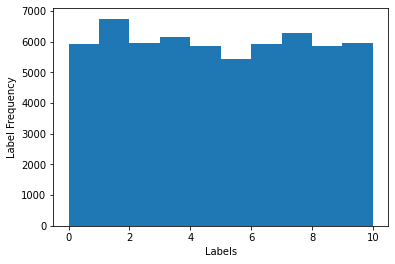

In [5]:
plt.figure()
plt.hist(Y_dev, bins = range(11))
plt.xlabel("Labels")
plt.ylabel("Label Frequency")
plt.show()

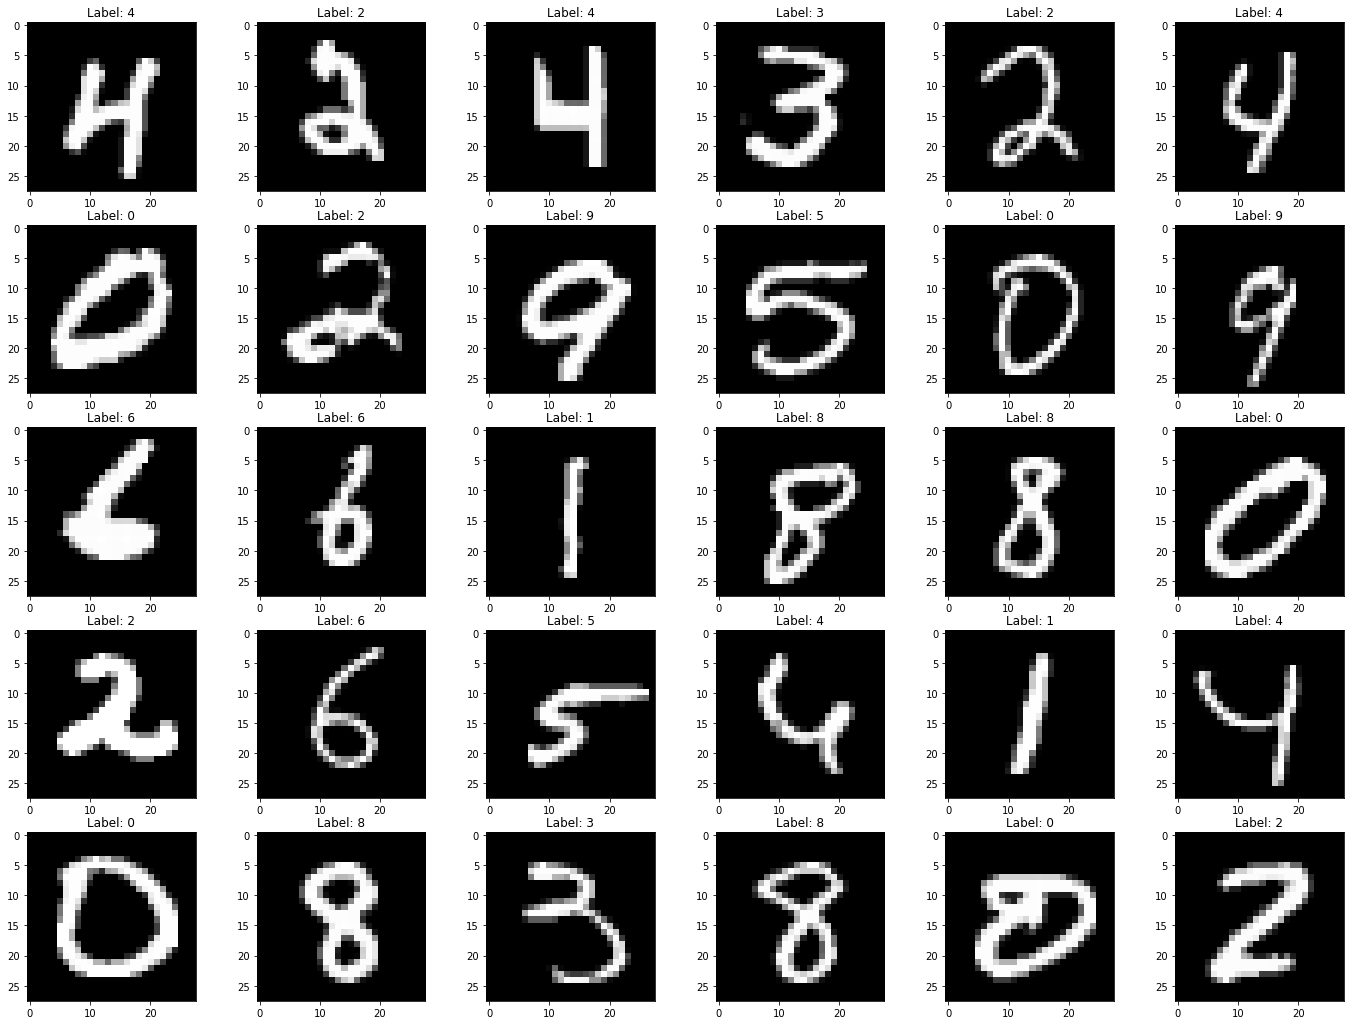

In [6]:
# Displaying some samples from the development set
sample_indexes = np.random.choice(np.arange(X_dev.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_dev[jj], cmap = "gray")
    plt.title("Label: %d" %Y_dev[jj])
plt.show()

In [7]:
#The number of classes across samples looks balanced
# Let's shuffle the samples and split them
indexes = np.arange(X_dev.shape[0], dtype = int)
np.random.shuffle(indexes)
X_dev = X_dev[indexes]
Y_dev = Y_dev[indexes]

nsplit = int(0.75*X_dev.shape[0]) # Train/validation split

# Train and validation split
X_train = X_dev[:nsplit]
Y_train = Y_dev[:nsplit]
X_val = X_dev[nsplit:]
Y_val = Y_dev[nsplit:]

print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)


Train set
Images:  (45000, 28, 28)
Labels shape:  (45000,)

Validation set
Images:  (15000, 28, 28)
Labels shape:  (15000,)


In [8]:
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_val.min(),X_val.max(),X_val.mean(),X_val.std())

0 255 33.310045946712016 78.54891781751965
0 255 33.343547959183674 78.62317480531043


# 2. Data Scaling

In [9]:
norm_type = 0 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train = X_train/255
    X_val = X_val/255
    X_test = X_test/255
elif norm_type == 1:
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std
else:
    pass

# 3. One Hot encoding

In [10]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)
Y_test_oh = tf.keras.utils.to_categorical(Y_test)

print("Labels:")
print(Y_train[:5])
print()
print("One hot encoded labels:")
print(Y_train_oh[:5])

Labels:
[1 4 7 9 6]

One hot encoded labels:
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


## 4. Define your model, cost function, optimizer, learning rate

In [11]:
def my_model(ishape = (28,28,1), k=10, lr=1e-4): # 28x28 is the shape of the images we have, 1 means that there is one channel, because the images are grayscale
  input_model = tf.keras.layers.Input(shape=ishape) # 0 parameters
  l1 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu')(input_model) # l1 = first layer, 32 is the number of convolutional filters, (3,3) is kernel size, 32*3*3*1 + 32 (bias for each filter) = 320 parameters
  l2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu')(l1) # 32*3*3*32+32
  l3 = tf.keras.layers.MaxPool2D(2,2)(l2) # 0 parameters, MaxPool layer
  l4 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu')(l3) # 64*3*3*32+64
  l5 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu')(l4) # 64*3*3*64+64
  l6 = tf.keras.layers.MaxPool2D(2,2)(l5) # 0 parameters, MaxPool layer
  flat = tf.keras.layers.Flatten()(l6)
  out = tf.keras.layers.Dense(10, activation='softmax')(flat) # 10 because we have 10 classes (numbers 0 to 9), activation is softmax because we want the outputs to represent probabilities of each of the classes
  model = tf.keras.models.Model(inputs=input_model, outputs=out)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [12]:
model = my_model()
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0     

## 5. Define your callbacks (save your model, patience, etc.)

- [Keras callbacks](https://keras.io/api/callbacks/)

In [13]:
model_name = "best_model_mnist_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 6. Train your model

In [14]:
model.fit(X_train[:,:,:,np.newaxis],Y_train_oh,batch_size = 32, epochs = 10, verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val[:,:,:,np.newaxis],Y_val_oh)) #representation needs to be [number of samples, size of image, number of channels], np.newaxis is called to represent the 1-channel grayscale

Epoch 1/10
1407/1407 [==============================] - 13s 4ms/step - loss: 1.1794 - accuracy: 0.6436 - val_loss: 0.2251 - val_accuracy: 0.9339
Epoch 2/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.1995 - accuracy: 0.9411 - val_loss: 0.1544 - val_accuracy: 0.9525
Epoch 3/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.1287 - accuracy: 0.9626 - val_loss: 0.1172 - val_accuracy: 0.9660
Epoch 4/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.1071 - accuracy: 0.9701 - val_loss: 0.0951 - val_accuracy: 0.9726
Epoch 5/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.0891 - accuracy: 0.9745 - val_loss: 0.0833 - val_accuracy: 0.9749
Epoch 6/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.0734 - accuracy: 0.9792 - val_loss: 0.0750 - val_accuracy: 0.9775
Epoch 7/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.0675 - accuracy: 0.9794 - val_loss: 0.0751 - val_accuracy

## 7. Test your model on the test and extract relevant metrics

In [15]:
model.load_weights(model_name)
metrics = model.evaluate(X_test[:,:,:,np.newaxis],Y_test_oh)
print("Categorical cross-entropy:", metrics[0])
print("Accuracy:", metrics[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0461 - accuracy: 0.9864
Categorical cross-entropy: 0.04614961892366409
Accuracy: 0.9864000082015991


136


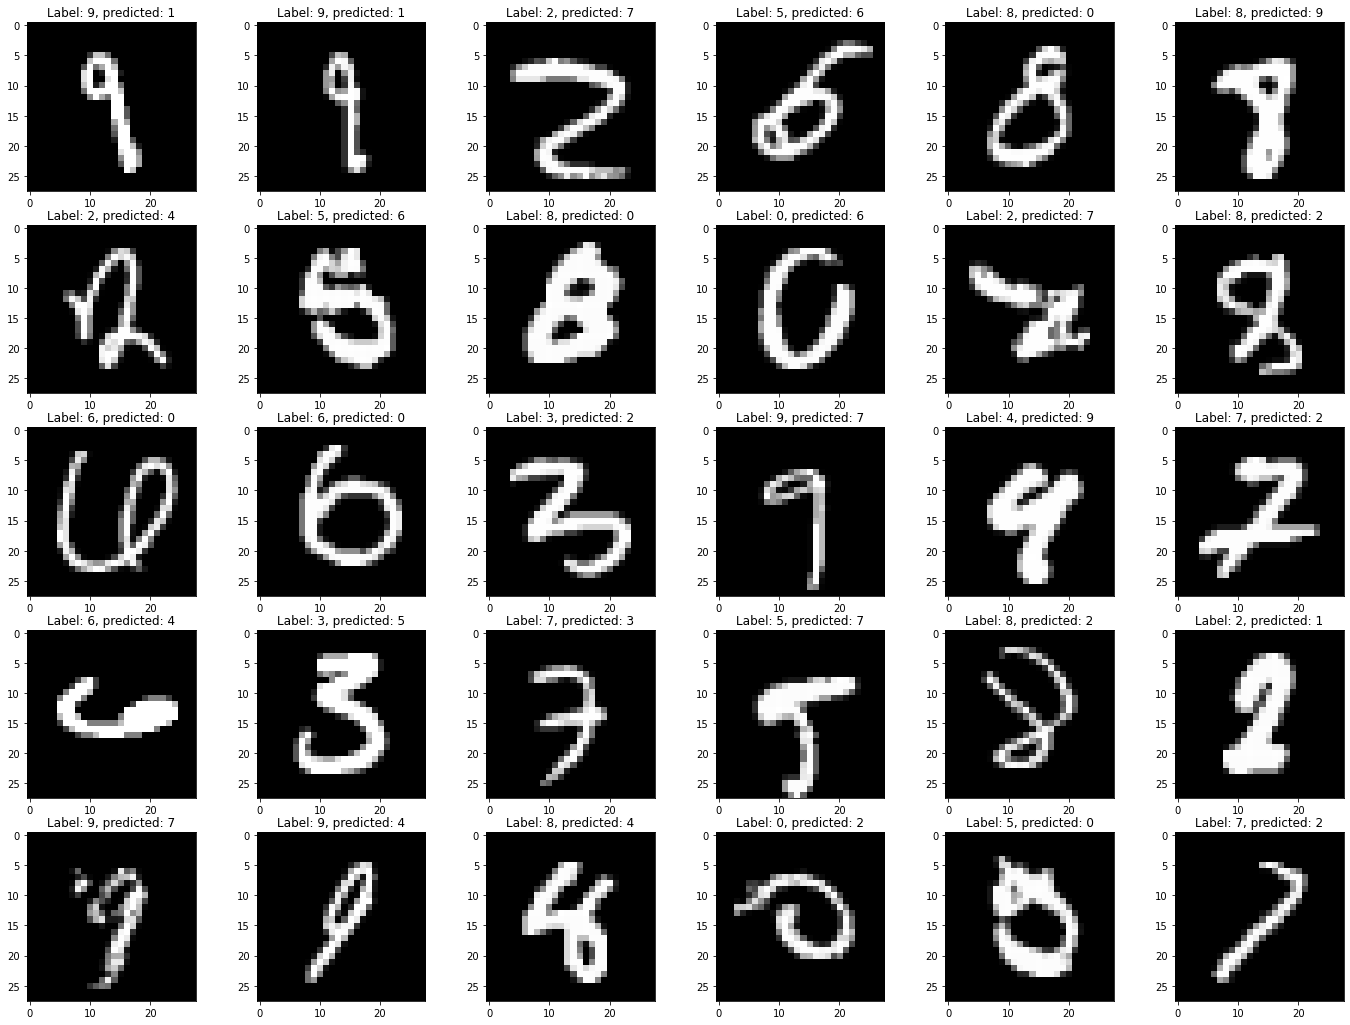

In [16]:
Ypred = model.predict(X_test[:,:,:,np.newaxis]).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()